# Caso Práctico: DBSCAN

## AUTOR: José Alamo Palomino

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

## Contexto

_Es importante que las compañías de tarjetas de crédito puedan reconocer transacciones fraudulentas de tarjetas de crédito para que a los clientes no se les cobre por los artículos que no compraron._

## Contenido

Los conjuntos de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeas.

Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos **492 fraudes de 284,807 transacciones**. El conjunto de datos está altamente desequilibrado, la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Contiene solo **variables de entrada numéricas que son el resultado de una transformación PCA**. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales y más información de fondo sobre los datos. 

**Las características V1, V2, ... V28 son los componentes principales obtenidos con PCA**, las únicas características que no se han transformado con PCA son **'Tiempo' y 'Cantidad'**. 

La función **'Tiempo'** contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. 

La característica **'Cantidad'** es la Cantidad de la transacción, esta característica se puede utilizar para el aprendizaje sensible al costo dependiente del ejemplo. 

La característica **'Clase'** es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

## Inspiración

* Identificar transacciones fraudulentas con tarjeta de crédito.

* Dada la relación de desequilibrio de clase, recomendamos medir la precisión utilizando el área bajo la curva de precisión-recuperación (AUPRC). La precisión de la matriz de confusión no es significativa para la clasificación desequilibrada.

 <h2 style = "color:darkorange">1. Importando librerías necesarias</h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np

 <h2 style = "color:darkorange">2. Funciones auxiliares</h2>

In [2]:
# Evaluación de la pureza
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

<h2 style = "color:darkorange">3. Lectura del conjunto de datos </h2>

In [3]:
df = pd.read_csv("Datasets/creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


<h2 style = "color:darkorange">4. Visualización del conjunto de datos</h2>

In [4]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [6]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


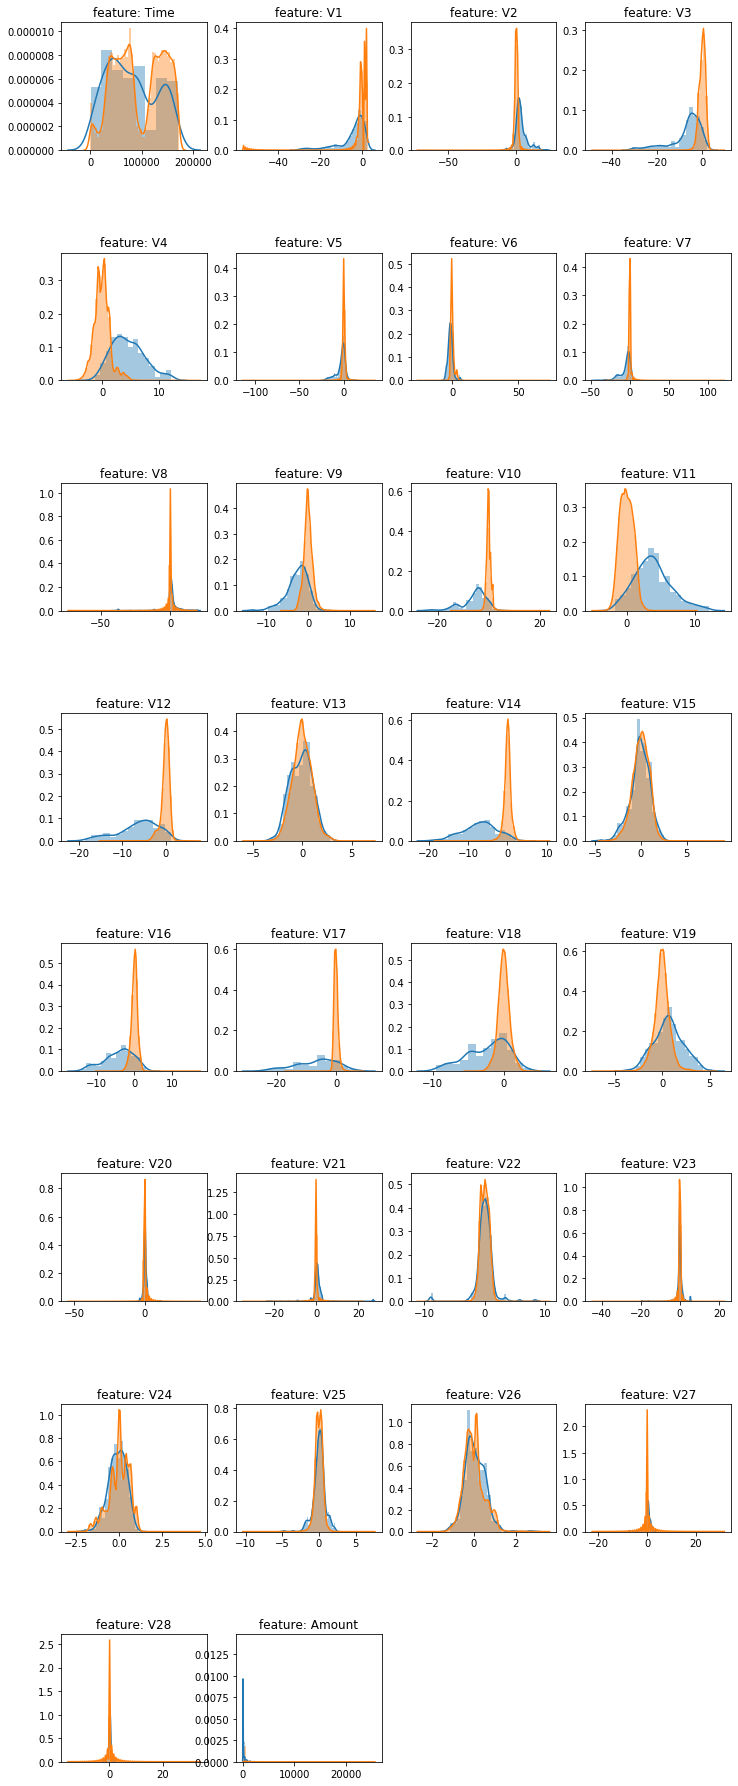

In [12]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 1])
    sns.distplot(df[f][df["Class"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

# Observamos a cada uno de los atributos de entrada, de tal manera que se pueda visualizar en cada uno de ellos cada una
# de las clases de la variable de salida. Los legítimos en azul y fraudulentos en naranja.

# Esta gráfica nos sirve para ver que características diferencian bastante bien los elementos positivos de los negativos
# (categorías de la variable respuesta).

# Para la variable Time, podemos observar que los elementos positivos y negativos se encuentran en el mismo rango y con 
# la misma densidad.

# La característica V4 si que va a diferenciar bastante los ejemplos positivos de los negativos, es decir, si que
# diferencia a las clases legítimas y fraudulentas. Entonces puede ser una característica bastante útil para utilizarla
# en diferenciar entre transacciones legítimas y fraudulentas.

# Similar comportamiento vemos en las variables V10, V11, V12, V14, V16 y V17.

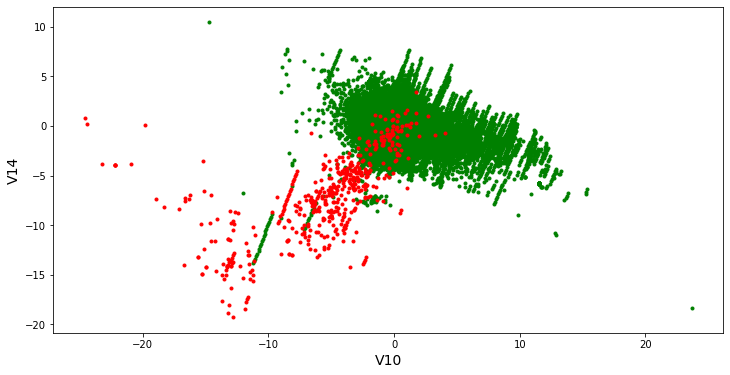

In [13]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

<h2 style = "color:darkorange">5. Preparación del conjunto de datos</h2> 

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [14]:
# Observando de analizar la representación gráfica de las características de entrada, vemos que las variables "Time" y 
# "Amount" no ayuda a diferenciar las transacciones legítimas de las fraudulentas, manteniendo un rango y densidad similar.
# Entonces eliminamos ambas variables.

df = df.drop(["Time", "Amount"], axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


<h2 style = "color:darkorange">6. DBSCAN con un conjunto de datos de dos dimensiones</h2>

**Antes de comenzar con el entrenamiento de DBSCAN para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.**

In [15]:
X = df[["V10", "V14"]].copy()
y = df["Class"].copy()

In [16]:
# De sklearn.cluster importamos la clase DBSCAN y la importamos en un objeto "dbscan", pasándole los parámetros
# eps=0.15 (radio) y min_samples=13 (número de clusters)

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=13)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.15, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=13, n_jobs=None, p=None)

In [17]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker=".", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

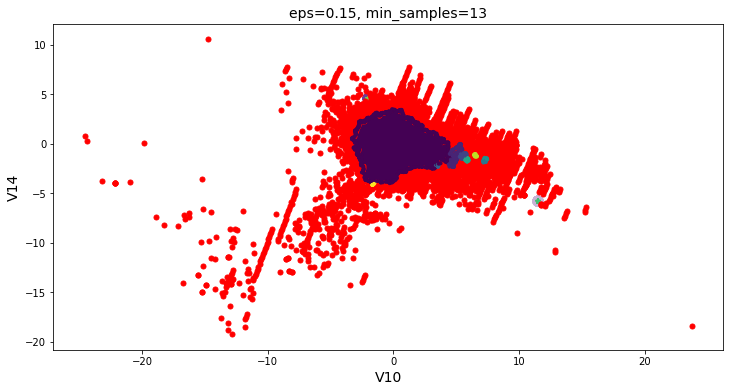

In [18]:
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X.values, size=100)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Observamos la agrupación de los clusters por colores, rojo es un cluster, morado otro cluster, amarillo otro, azul, etc. DBSCAN no solo clasifica las observaciones en clusters, sino que también localizaba ejemplos de ruído, estos, como ejemplos anómalos. Entonces todos esos ejemplos u observaciones que queden como ejemplos anómalos o de ruido se agruparán en una etiqueta de un clúster denominada -1.**

In [19]:
# Podemos observar que todos esos ejemplos que son clasificados como anómalos o ejemplos de ruido, se agruparan en una
# etiqueta de un cluster denominado -1.

# En el gráfico lo que está en rojo no es un clúster, sino son los ejemplos de ruido (-1). Entonces los ejemplos maliciosos
# han sido considerados como ruido.

# Label -1 has 3612 samples - 411 are malicious samples
# Es decir, la mayoría de ejemplos maliciosos (transacciones fraudulentas) no se han clasificado dentro de un cluster, sino
# se han sonsiderado ejemplos de ruido (noisepoints).

# A efectos prácticos, podemos considerar estos ejemplos de ruido (-1) como un clúster.

counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label -1 has 3612 samples - 411 are malicious samples
Label 0 has 280757 samples - 81 are malicious samples
Label 1 has 261 samples - 0 are malicious samples
Label 2 has 50 samples - 0 are malicious samples
Label 3 has 13 samples - 0 are malicious samples
Label 4 has 15 samples - 0 are malicious samples
Label 5 has 13 samples - 0 are malicious samples
Label 6 has 20 samples - 0 are malicious samples
Label 7 has 25 samples - 0 are malicious samples
Label 8 has 16 samples - 0 are malicious samples
Label 9 has 13 samples - 0 are malicious samples
Label 10 has 12 samples - 0 are malicious samples


<h2 style = "color:darkorange">7. DBSCAN con un conjunto de datos multidimensional</h2>

**Al tratarse de un algoritmo basado en aprendizaje no supervisado, no se requieren las etiquetas para entrenar o predecir. Hay que tener en cuenta que en este tipo de problemas se presupone que no se dispone de las etiquetas.**

In [18]:
# Separamos las características de entrada de la de salida.
X_full = df.drop("Class", axis=1)
y = df["Class"].copy()

In [19]:
# Variables o características de entrada
X_full

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


In [ ]:
# Entrenamos nuestro algoritmo DBSCAN con nuestra data completa
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.70, min_samples=25)
dbscan.fit(X_full)

In [ ]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

<h2 style = "color:darkorange">8. Reducción del número de características</h2>

In [20]:
# Separamos las características de entrada de la de salida.
X = df.drop("Class", axis=1)
y = df["Class"].copy()

In [21]:
# Variables o características de entrada
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


### Aplicamos selección de características con _Random Forest_

In [22]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [24]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()

In [25]:
X_reduced

,V17,V14,V16,V12,V10,V11,V18
0,0.207971,-0.311169,-0.470401,-0.617801,0.090794,-0.551600,0.025791
1,-0.114805,-0.143772,0.463917,1.065235,-0.166974,1.612727,-0.183361
2,1.109969,-0.165946,-2.890083,0.066084,0.207643,0.624501,-0.121359
3,-0.684093,-0.287924,-1.059647,0.178228,-0.054952,-0.226487,1.965775
4,-0.237033,-1.119670,-0.451449,0.538196,0.753074,-0.822843,-0.038195
...,...,...,...,...,...,...,...
284802,1.991691,4.626942,1.107641,2.711941,4.356170,-1.593105,0.510632
284803,-0.025693,-0.675143,-0.711757,0.915802,-0.975926,-0.150189,-1.221179
284804,0.313502,-0.510602,0.140716,0.063119,-0.484782,0.411614,0.395652
284805,0.509928,0.449624,-0.608577,-0.962886,-0.399126,-1.933849,1.113981


### Entrenamiento de DBSCAN con el conjunto de datos reducido

In [27]:
from sklearn.cluster import DBSCAN

# Entrenamos nuestro algoritmo DBSCAN

# Lo recomendable es utilizar las técnicas de árboles de decisión y random forest para buscar formas de hiperparámetros
# de manera automática como Resultados de búsqueda (RandomizedSearch). Pero DBSCAN toma demasiado tiempo en entrenarse.

dbscan = DBSCAN(eps=0.70, min_samples=25)
dbscan.fit(X_reduced)

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=25, n_jobs=None, p=None)

In [28]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

# Como noise points tenemos a casi todos nuestros ejemplos maliciosos (transacciones fraudulentas). En este caso tenemos
# 24588 registros o ejemplos. El resto de clusters está formado por ejemplos legítimos, expecto el cero.

# En conclusión, nuestro algoritmo DBSCAN se ha comportado bastante mejor con un número de dimensiones más pequeño. Es
# decir, con un conjunto de características de entrada menor.

Label -1 has 24588 samples - 445 are malicious samples
Label 0 has 257605 samples - 47 are malicious samples
Label 1 has 980 samples - 0 are malicious samples
Label 2 has 1126 samples - 0 are malicious samples
Label 3 has 75 samples - 0 are malicious samples
Label 4 has 44 samples - 0 are malicious samples
Label 5 has 86 samples - 0 are malicious samples
Label 6 has 26 samples - 0 are malicious samples
Label 7 has 31 samples - 0 are malicious samples
Label 8 has 55 samples - 0 are malicious samples
Label 9 has 25 samples - 0 are malicious samples
Label 10 has 67 samples - 0 are malicious samples
Label 11 has 17 samples - 0 are malicious samples
Label 12 has 46 samples - 0 are malicious samples
Label 13 has 36 samples - 0 are malicious samples


<h2 style = "color:darkorange">9. Evaluación de los resultados</h2>

Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.

In [29]:
# Obtenemos los clusters del objeto dbscan
clusters = dbscan.labels_
clusters

array([ 0,  0,  0, ...,  0, -1,  0], dtype=int64)

In [30]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas

print("Purity Score:", purity_score(y, clusters))

# El purity score es del 99.82%, porque la mayoría de los clusters son puros, esto a consecuencia de que tenemos 
# una data está desequilibrada, entonces la pureza quizá no sea la mejor métrica para evaluar un conjunto de datos
# desequilibrado.

Purity Score: 0.9982725143693799


In [31]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
# sample_size=10000 -> evalua el coeficiente de shiloutte en un subconjunto ya que tarda demasiado en cargar el resultado.

print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))

# Cuando el valor es cercano a cero quiere decir que los clústers se superponen.

Shiloutte:  0.12070563018462262


In [28]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas

print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

# Con DBSCAN obtenemos un valor de 913.711950589592 y con kmeans un valor de Calinski de 40537.024698689966, esto quiere 
# decir que Kmeans está agrupando los ejemplos mejor que DBSCAN.

Calinski harabasz:  913.711950589592


<h2 style = "color:darkorange">10. Problemas típicos que pueden resolverse con DBSCAN</h2>

DBSCAN es útil para solucionar problemas como el que se plantea a continuación.

In [32]:
# Generamos un conjunto de datos
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

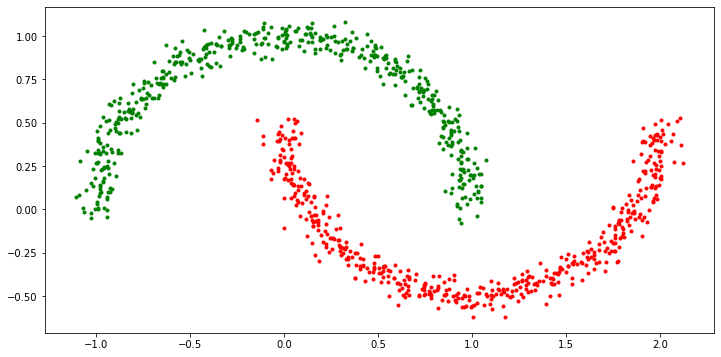

In [33]:
# Tenemos 2 clases, ejemplos positivos (verde) y ejemplos negativos (rojo)
# Observamos que sonn clusters no esféricos (make_moons -> forma de luna)

plt.figure(figsize=(12, 6))
plt.scatter(X[:,0][y == 0], X[:,1][y == 0], c="g", marker=".")
plt.scatter(X[:,0][y == 1], X[:,1][y == 1], c="r", marker=".")
plt.show()

In [34]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=6)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=6, n_jobs=None, p=None)

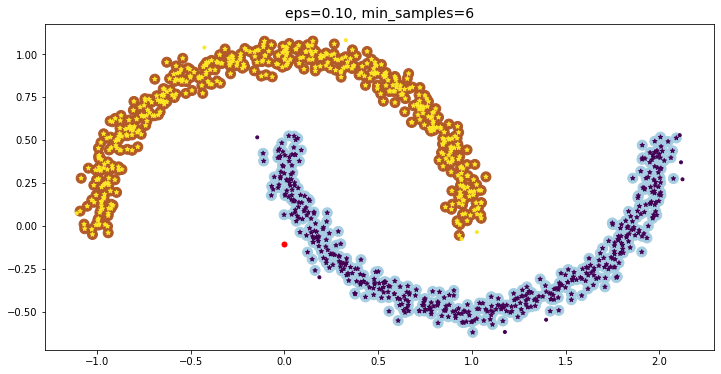

In [35]:
# Representamos el límite de decisión
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X, size=100)
plt.show()

In [33]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

# Ha formado 2 clusters y 1 nosepoint.

Label -1 has 1 samples - 1 are malicious samples
Label 0 has 499 samples - 499 are malicious samples
Label 1 has 500 samples - 0 are malicious samples
